# Descargar dataset

In [1]:
# Descargar el dataset NSL-KDD desde GitHub
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt


--2026-02-15 19:07:42--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2026-02-15 19:07:43 (177 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]

--2026-02-15 19:07:43--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Saving

# Import librerías utilizadas

In [2]:
# =========================
# Librerías base
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Preprocesamiento
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# =========================
# Modelos
# =========================
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# =========================
# Métricas y evaluación
# =========================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    balanced_accuracy_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)


# Clasificación binaria (normal/ataque)


In [3]:


# Definir nombres de columnas según la especificación oficial del dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Leer los archivos
train_df = pd.read_csv('KDDTrain+.txt', names=columns)
test_df = pd.read_csv('KDDTest+.txt', names=columns)



In [4]:

# Crear columna binaria 'attack' (1 si es ataque, 0 si es normal)
train_df['attack'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['attack'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Eliminar columna original 'label'
train_df.drop(columns=['label'], inplace=True)
test_df.drop(columns=['label'], inplace=True)

# Eliminar columna original 'difficulty_level'
train_df.drop(columns=['difficulty_level'], inplace=True)
test_df.drop(columns=['difficulty_level'], inplace=True)

train_df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


# Duplicados y ctes.

In [5]:
train_df = train_df.drop_duplicates().copy()
test_df  = test_df.drop_duplicates().copy()

In [6]:
# Buscar columnas con un solo valor único
constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]

In [7]:
# Eliminar las columnas constantes
train_df.drop(columns=constant_cols, inplace=True)
test_df.drop(columns=constant_cols, inplace=True)


# Pipeline

## Split interno (X_tr/X_val)

In [8]:
# Paso 1 — Separar X/y y crear split de validación estratificado


# 1) Definimos columnas de entrada y la variable objetivo
target_col = 'attack'
feature_cols = [c for c in train_df.columns if c != target_col]

X = train_df[feature_cols]
y = train_df[target_col].astype(int)

# 2) Split interno para validación (sin tocar el test oficial)
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.20,         # 20% para validación
    stratify=y,             # estratificación por la clase
    random_state=42
)



## Transformación variables categóricas y escalado de binarias

In [9]:


# 1 Columnas categóricas (nominales)
cat_cols = train_df.select_dtypes(include='object').columns.tolist()

# 2️ Columnas numéricas (todas las demás, incluidas las binarias 0/1)
num_cols = [c for c in X_tr.columns if c not in cat_cols]

# 3️ Definimos el transformador
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


## Modelo Base (Regresión Logística)

In [10]:

# Definimos el modelo base
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    solver='lbfgs',
    random_state=42
)


In [11]:


# Unimos preprocesamiento y modelo
modeloBase = Pipeline(steps=[
    ('preprocesamiento', preprocess),
    ('clasificador', logreg)
])

# Entrenar con el split de train
modeloBase.fit(X_tr, y_tr)


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'nu...
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate', ...])],
                                   verbose_feature_names_out=False)),
                ('clasificador',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=42))])

## Random Forest

In [12]:
# -------------------------
# Random Forest
# -------------------------
rf_pipe = Pipeline(steps=[
    ("preprocesamiento", preprocess),
    ("clasificador", RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
))
])
rf_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'nu...
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate', ...])],
                                   verbose_feature_names_out=False)),
                ('clasificador',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

## XGBoost


In [13]:
# -------------------------
# XGBoost
# -------------------------
xgb_pipe = Pipeline(steps=[
    ('preprocesamiento', preprocess),
    ('clasificador', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'nu...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

## Linear SVM

In [14]:

# -------------------------
# Linear SVM
# -------------------------
svm_pipe = Pipeline(steps=[
    ("preprocesamiento", preprocess),
    ("clasificador", LinearSVC(
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    ))
])

svm_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'nu...
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate', ...])],
                                   verbose_feature_names_out=False)),
                ('clasificador',
                 LinearSVC(class_weight='balanced', max_iter=5000,
                           random_state=42))])

## Evaluación de los modelos

In [15]:
def evaluate_model(model, X_test, y_test, threshold, name="model"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("El modelo no proporciona score continuo.")

    y_score = np.asarray(y_score).ravel()
    y_pred = (y_score >= threshold).astype(int)

    return {
        "Modelo": name,
        "Umbral": threshold,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision(Attack)": precision_score(y_test, y_pred, pos_label=1),
        "Recall(Attack)": recall_score(y_test, y_pred, pos_label=1),
        "F1(Attack)": f1_score(y_test, y_pred, pos_label=1),
        "F2(Attack)": fbeta_score(y_test, y_pred, beta=2, pos_label=1),
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "PR-AUC": average_precision_score(y_test, y_score)
    }



# Optimización de umbral

In [16]:
import numpy as np
from sklearn.metrics import fbeta_score

def best_threshold_f2(model, X_val, y_val, beta=2, pos_label=1, n_steps=200):
    """
    Devuelve (best_t, best_f2) maximizando F_beta en validación.
    - Si hay predict_proba: usa P(y=1)
    - Si hay decision_function: usa score continuo (margen)
    """
    # 1) obtener score continuo
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_val)
    else:
        raise ValueError("El modelo no tiene predict_proba ni decision_function.")

    scores = np.asarray(scores).ravel()

    # 2) construir candidatos de umbral
    thresholds = np.unique(np.quantile(scores, np.linspace(0.0, 1.0, n_steps)))


    # 3) escoger el mejor
    best_t, best_f = None, -1
    for t in thresholds:
        y_pred = (scores >= t).astype(int)
        f = fbeta_score(y_val, y_pred, beta=beta, pos_label=pos_label)
        if f > best_f:
            best_f, best_t = f, t

    return best_t, best_f


In [17]:
t_logreg, f2_logreg    =   best_threshold_f2(modeloBase, X_val, y_val, beta=2)
t_rf,     f2_rf        =   best_threshold_f2(rf_pipe, X_val, y_val, beta=2)
t_xgb,    f2_xgb       =   best_threshold_f2(xgb_pipe, X_val, y_val, beta=2)
t_svm,    f2_svm       =   best_threshold_f2(svm_pipe, X_val, y_val, beta=2)

print(f"LogReg: t={t_logreg:.2f} | F2_valid={f2_logreg:.4f}")
print(f"RF:     t={t_rf:.2f} | F2_valid={f2_rf:.4f}")
print(f"XGB:    t={t_xgb:.2f} | F2_valid={f2_xgb:.4f}")
print(f"SVM:    t={t_svm:.2f} | F2_valid={f2_svm:.4f}")

LogReg: t=0.19 | F2_valid=0.9795
RF:     t=0.15 | F2_valid=0.9988
XGB:    t=0.02 | F2_valid=0.9988
SVM:    t=-0.31 | F2_valid=0.9787


# Obtención de resultados

In [18]:
# Variables de test
X_test = test_df.drop(columns=['attack'])
y_test = test_df['attack'].astype(int)

results = []

# LogReg umbral 0.50
results.append(evaluate_model(modeloBase, X_test, y_test, threshold=0.50, name="LogReg (t=0.50)"))

# LogReg umbral óptimo por F2
results.append(evaluate_model(modeloBase, X_test, y_test, threshold=t_logreg, name=f"LogReg (t={t_logreg:.2f}, opt F2)"))

# RandomForest umbral 0.50
results.append(evaluate_model(rf_pipe, X_test, y_test, threshold=0.50, name="RandomForest (t=0.50)"))

# RandomForest umbral óptimo por F2
results.append(evaluate_model(rf_pipe, X_test, y_test, threshold=t_rf, name=f"RandomForest (t={t_rf:.2f}, opt F2)"))

# XGBoost umbral 0.50
results.append(evaluate_model(xgb_pipe, X_test, y_test, threshold=0.50, name="XGBoost (t=0.50)"))

# XGBoost umbral óptimo por F2
results.append(evaluate_model(xgb_pipe, X_test, y_test, threshold=t_xgb, name=f"XGBoost (t={t_xgb:.2f}, opt F2)"))

# Linear SVM umbral 0
results.append(evaluate_model(svm_pipe, X_test, y_test, threshold=0, name="Linear SVM (t=0)"))

# Linear SVM umbral óptimo por F2
results.append(evaluate_model(svm_pipe, X_test, y_test, threshold=t_svm, name=f"Linear SVM (t={t_svm:.2f}, opt F2)"))

df_results = pd.DataFrame(results)

# Ordenar para que se vea claro el "mejor" según F2
df_results = df_results.sort_values(by="F2(Attack)", ascending=False).reset_index(drop=True)

display(
    df_results.style.format({
        "Umbral": "{:.2f}",
        "Accuracy": "{:.4f}",
        "Precision(Attack)": "{:.4f}",
        "Recall(Attack)": "{:.4f}",
        "F1(Attack)": "{:.4f}",
        "F2(Attack)": "{:.4f}",
        "Balanced Acc": "{:.4f}",
        "PR-AUC": "{:.4f}"
    })
)


,Modelo,Umbral,Accuracy,Precision(Attack),Recall(Attack),F1(Attack),F2(Attack),Balanced Acc,PR-AUC
0,"RandomForest (t=0.15, opt F2)",0.15,0.8590,0.9224,0.8214,0.8690,0.8398,0.8651,0.9663
1,"XGBoost (t=0.02, opt F2)",0.02,0.8485,0.9671,0.7598,0.8510,0.7938,0.8628,0.9701
2,"LogReg (t=0.19, opt F2)",0.19,0.7790,0.9080,0.6807,0.7781,0.7166,0.7948,0.8680
3,XGBoost (t=0.50),0.50,0.7973,0.9692,0.6650,0.7888,0.7095,0.8185,0.9701
4,"Linear SVM (t=-0.31, opt F2)",-0.31,0.7658,0.9100,0.6532,0.7605,0.6923,0.7839,0.8682
5,LogReg (t=0.50),0.50,0.7549,0.9167,0.6263,0.7442,0.6687,0.7756,0.8680
6,Linear SVM (t=0),0.00,0.7535,0.9154,0.6247,0.7426,0.6671,0.7742,0.8682
7,RandomForest (t=0.50),0.50,0.7698,0.9678,0.6161,0.7529,0.6643,0.7945,0.9663


# Matrices de confusión y gráficas

In [19]:


def plot_confusion_matrix(
    model,
    X,
    y,
    threshold=0.5,
    name="model",
    labels=("Normal", "Ataque")
):

    # Score continuo (MISMA lógica que evaluate_model)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
        y_pred = (y_score >= threshold).astype(int)

    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
        y_pred = (y_score >= threshold).astype(int)

    else:
        y_score = None
        y_pred = model.predict(X)

    # Matriz de confusión
    cm = confusion_matrix(y, y_pred, normalize=None) # descomentar para matriz absoluta
    #cm = confusion_matrix(y, y_pred, normalize="true") # descomentar para matriz normalizada

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(labels)
    )

    disp.plot(values_format="d", cmap="Blues")   # descomentar para matriz absoluta
    #disp.plot(values_format=".2f")              # descomentar para matriz normalizada

    # Título informativo y limpio (TFG-friendly)
    if y_score is None:
        title = f"Matriz de confusión | {name} | predict()"
    else:
        title = f"Matriz de confusión | {name} | umbral={threshold:.2f}"

    plt.title(title)
    plt.xlabel("Predicción del modelo")
    plt.ylabel("Valor real")
    plt.tight_layout()
    plt.show()

    return cm

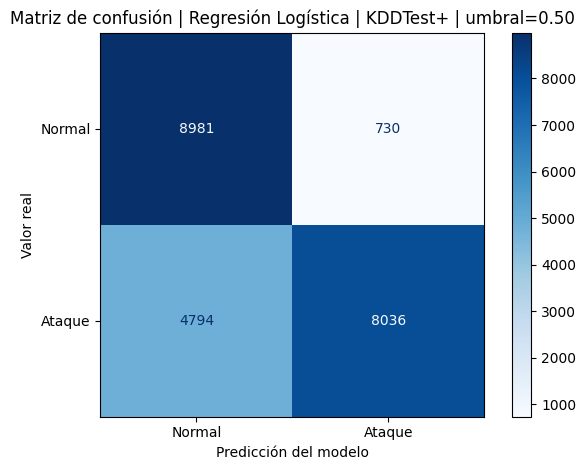

array([[8981,  730],
       [4794, 8036]])

In [20]:
plot_confusion_matrix(
    modeloBase,
    X_test,
    y_test,
    threshold=0.5,
    name="Regresión Logística | KDDTest+"
)


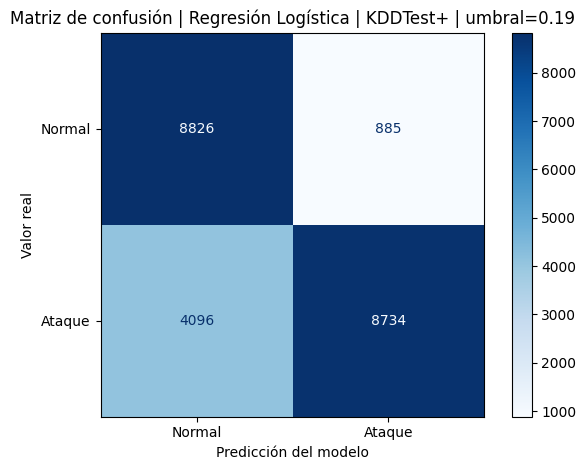

array([[8826,  885],
       [4096, 8734]])

In [21]:
plot_confusion_matrix(
    modeloBase,
    X_test,
    y_test,
    threshold=t_logreg,
    name="Regresión Logística | KDDTest+"
)


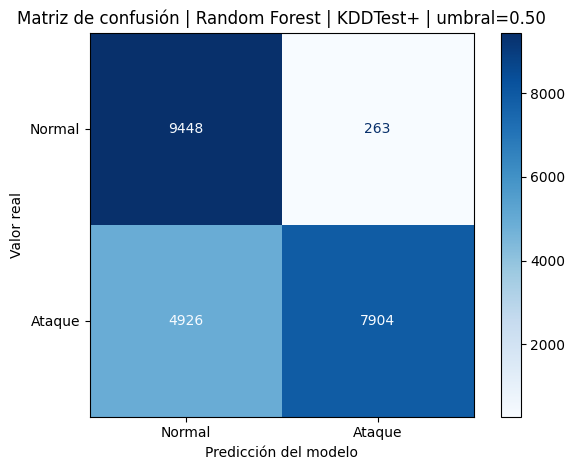

array([[9448,  263],
       [4926, 7904]])

In [22]:
plot_confusion_matrix(
    rf_pipe,
    X_test,
    y_test,
    threshold=0.5,
    name="Random Forest | KDDTest+"
)

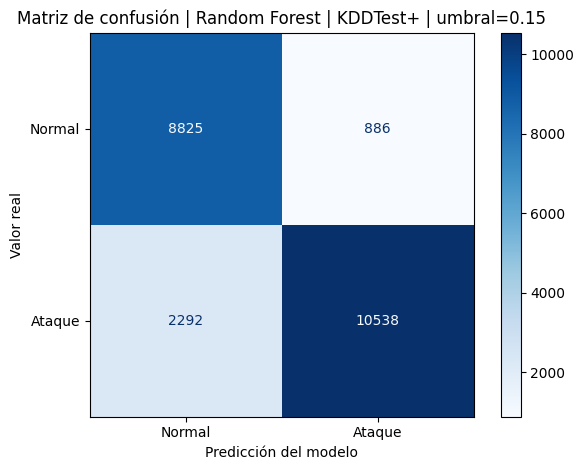

array([[ 8825,   886],
       [ 2292, 10538]])

In [23]:
plot_confusion_matrix(
    rf_pipe,
    X_test,
    y_test,
    threshold=t_rf,
    name="Random Forest | KDDTest+"
)

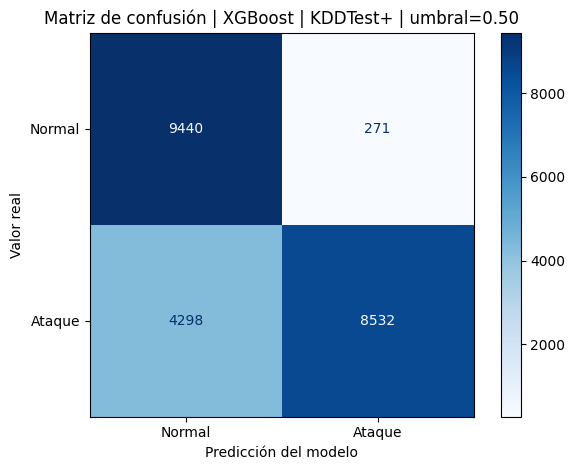

array([[9440,  271],
       [4298, 8532]])

In [24]:
plot_confusion_matrix(
    xgb_pipe,
    X_test,
    y_test,
    threshold=0.5,
    name="XGBoost | KDDTest+"
)

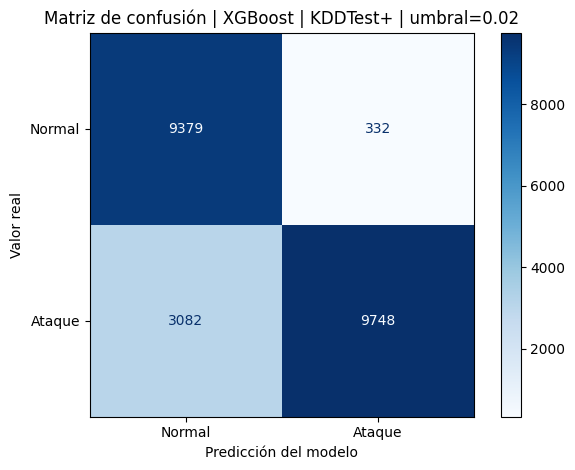

array([[9379,  332],
       [3082, 9748]])

In [25]:
plot_confusion_matrix(
    xgb_pipe,
    X_test,
    y_test,
    threshold=t_xgb,
    name="XGBoost | KDDTest+"
)

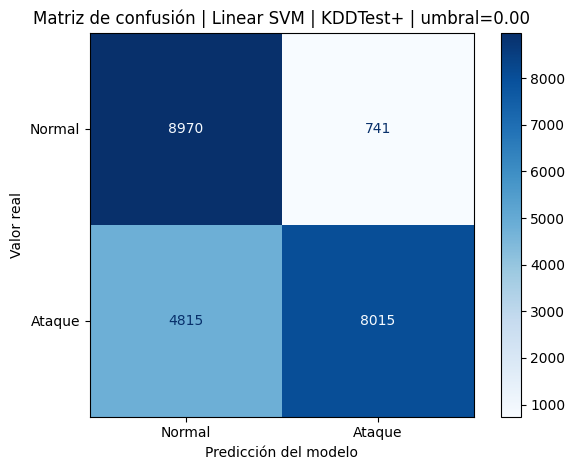

array([[8970,  741],
       [4815, 8015]])

In [26]:
plot_confusion_matrix(
    svm_pipe,
    X_test,
    y_test,
    threshold=0,
    name="Linear SVM | KDDTest+"
)

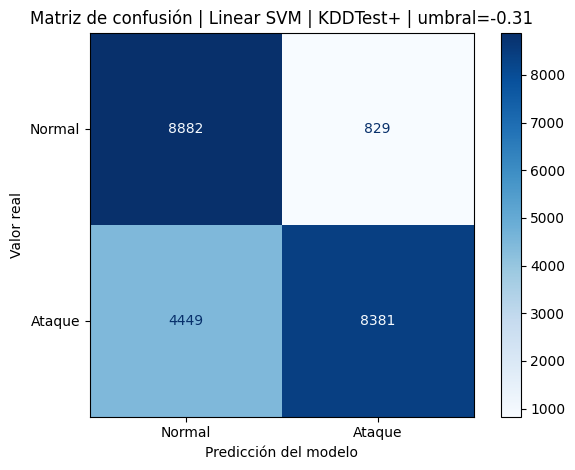

array([[8882,  829],
       [4449, 8381]])

In [27]:
plot_confusion_matrix(
    svm_pipe,
    X_test,
    y_test,
    threshold=t_svm,
    name="Linear SVM | KDDTest+"
)

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def plot_pr_curve_two_thresholds(
    model,
    X,
    y,
    threshold_default,
    threshold_opt,
    name="model",
    positive_label=1
):
    """
    Dibuja la curva Precision-Recall y marca dos puntos:
    - Umbral por defecto
    - Umbral óptimo (por F2)
    Sin anotaciones de texto en los puntos (solo leyenda).
    """

    # Score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        raise ValueError(
            f"{name}: el modelo no expone predict_proba() ni decision_function()"
        )

    # Curva Precision-Recall
    precision, recall, thr = precision_recall_curve(
        y, y_score, pos_label=positive_label
    )

    # PR-AUC
    pr_auc = average_precision_score(y, y_score)

    # Plot curva
    plt.figure()
    plt.plot(
        recall,
        precision,
        linewidth=1.5,
        label=f"PR curve | PR-AUC = {pr_auc:.4f}"
    )

    # Función auxiliar para marcar puntos (sin texto)
    def mark_threshold_point(threshold, color, label):
        if thr is None or len(thr) == 0:
            return
        idx = int(np.argmin(np.abs(thr - threshold)))
        plt.scatter(
            recall[idx],
            precision[idx],
            color=color,
            s=70,
            zorder=3,
            label=label
        )

    # Marcar umbral por defecto (azul)
    mark_threshold_point(
        threshold_default,
        color="tab:blue",
        label="Umbral por defecto"
    )

    # Marcar umbral óptimo (rojo)
    mark_threshold_point(
        threshold_opt,
        color="tab:red",
        label="Umbral optimizado en F2"
    )

    plt.title(f"Curva Precision–Recall | {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()

    return pr_auc


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_pr_curves_default(models_dict, X, y, positive_label=1, title="Curvas Precision-Recall (umbrales por defecto)"):
    """
    Dibuja en una sola figura las curvas Precision-Recall de varios modelos
    usando su salida continua (predict_proba/decision_function).

    models_dict: dict {"Nombre modelo": modelo_pipeline}
    X, y: datos de evaluación
    """

    plt.figure()

    for name, model in models_dict.items():
        # Score continuo
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X)
        else:
            # Sin score continuo no se puede hacer PR curve
            print(f"[AVISO] {name}: no tiene predict_proba() ni decision_function(); se omite.")
            continue

        precision, recall, _ = precision_recall_curve(y, y_score, pos_label=positive_label)
        pr_auc = average_precision_score(y, y_score)

        plt.plot(recall, precision, linewidth=1, label=f"{name} | PR-AUC={pr_auc:.4f}")

    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()


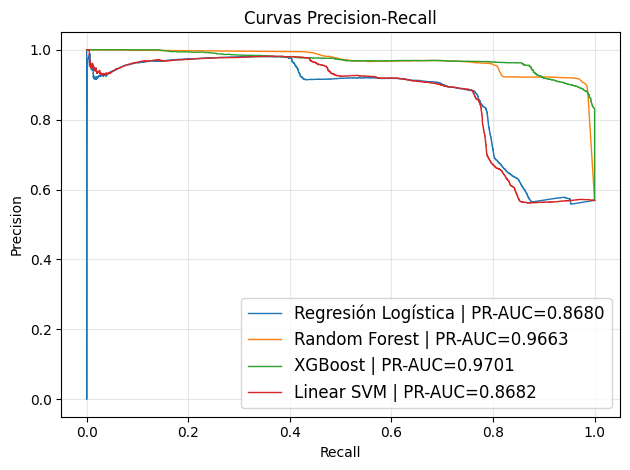

In [30]:
models_default = {
    "Regresión Logística": modeloBase,
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe,
    "Linear SVM": svm_pipe
}

plot_pr_curves_default(models_default, X_test, y_test,
                       title="Curvas Precision-Recall")
